In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

In [3]:
# pandas를 이용하여 excel파일의 데이터를 가져옵니다. 321일치의 데이터가 있음을 확인해 볼 수 있습니다.
d = pd.read_excel('C:\\Users\mingu\Desktop\\2020_covid19_KR_seoul.xlsx')

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   date                                                      321 non-null    datetime64[ns]
 1   retail_and_recreation_percent_change_from_baseline        321 non-null    int64         
 2   grocery_and_pharmacy_percent_change_from_baseline         321 non-null    int64         
 3   parks_percent_change_from_baseline                        321 non-null    int64         
 4   transit_stations_percent_change_from_baseline             321 non-null    int64         
 5   workplaces_percent_change_from_baseline                   321 non-null    int64         
 6   residential_percent_change_from_baseline                  321 non-null    int64         
 7   seoul_retail_and_recreation_percent_change_f

In [5]:
# 각각의 feature들의 이름을 출력하여 봅시다.
col_names = list(d.columns)
i = 0
for n in col_names:
    print(f'feature {i}: {n}')
    i=i+1

feature 0: date
feature 1: retail_and_recreation_percent_change_from_baseline
feature 2: grocery_and_pharmacy_percent_change_from_baseline
feature 3: parks_percent_change_from_baseline
feature 4: transit_stations_percent_change_from_baseline
feature 5: workplaces_percent_change_from_baseline
feature 6: residential_percent_change_from_baseline
feature 7: seoul_retail_and_recreation_percent_change_from_baseline
feature 8: seoul_grocery_and_pharmacy_percent_change_from_baseline
feature 9: seoul_parks_percent_change_from_baseline
feature 10: seoul_transit_stations_percent_change_from_baseline
feature 11: seoul_workplaces_percent_change_from_baseline
feature 12: seoul_residential_percent_change_from_baseline
feature 13: confirmed_new
feature 14: deaths_new
feature 15: recovered_new


In [6]:
# target : 새로 확진된 사람의 수 - feature 13: confirmed_new
# 13번째 feature인 새로 확진된 사람의 숫자를 y(target)로 합니다.
# 우리는 1주 전의 데이터를 통해 1주 후를 예측하고자 하므로, 7번째 날짜부터의 데이터를 y로 가져오겠습니다.
y = d.iloc[7:,13].to_numpy()
print(y.shape)

(314,)


In [7]:
# 몇 개의 feature를 선정하여 input data X로 가져오겠습니다.
# 마지막 7일치 데이터는 target이 존재하지 않으므로, 이는 빼고 가져오도록 합니다.
X = d.iloc[:-7,[2,6,5,4,7,8,3,12]].to_numpy()
print(X.shape)

(314, 8)


In [8]:
# model 학습에 사용하기 위해 X, y를 모두 pytorch의 floattensor로 변환합니다.
X = torch.tensor(X).type(torch.FloatTensor)
y = torch.tensor(y).type(torch.FloatTensor)

In [9]:
X.shape

torch.Size([314, 8])

In [10]:
y.shape

torch.Size([314])

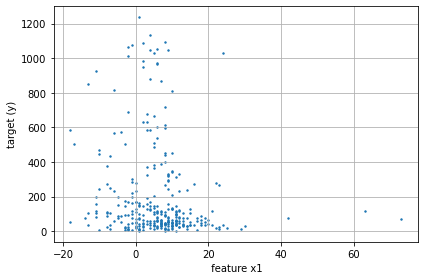

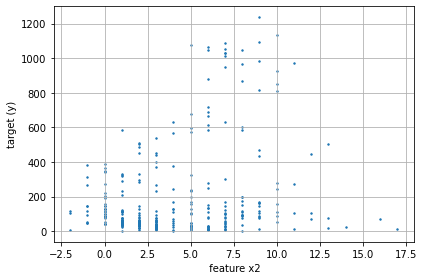

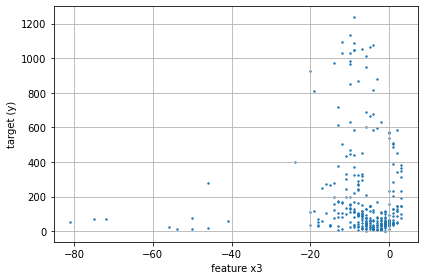

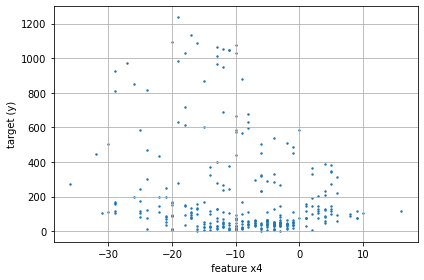

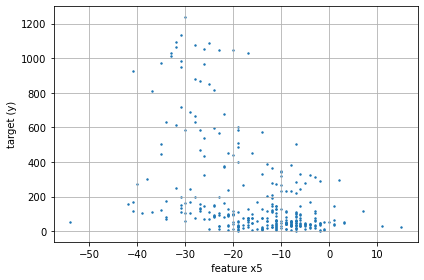

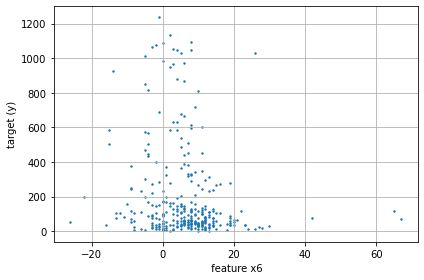

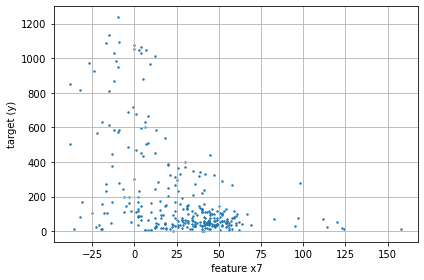

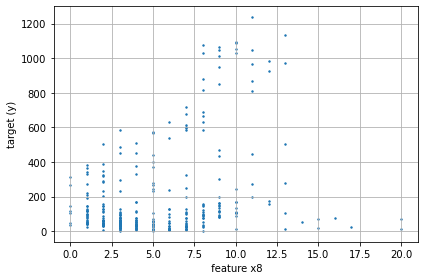

In [11]:
# 각각의 feature와 y의 관계를 그래프로 확인합니다.
for n in range(X.shape[-1]):
    plt.scatter(X[:,n],y,2)
    plt.xlabel(f' feature x{n+1}')
    plt.ylabel('target (y)')
    plt.grid('on')
    plt.tight_layout()
    plt.show()

### 파이썬코드 작성 및 실행 ###
- 불러온 데이터에 대해 학습을 진행할 수 있도록 필요한 model, loss function, optimization algorithm, data loader를 정의하고, 적절한 하이퍼파라미터를 설정하여 모델을 학습시켜 봅니다.
- 아래의 실습코드를 참고하여 네 개의 함수를 정의하고 하이퍼파라미터들을 학습결과를 보며 최적화합니다.
- 학습결과가 만족스럽지 않은 경우 input feature의 종류를 변경하여 X를 다시 구성해봅시다.
- 아래 세 개의 cell에 코드를 넣어 진행하는 것을 권장하지만 필요시 새로운 cell을 추가하여도 괜찮습니다.

In [12]:
### model parameter 초기화 및 하이퍼파라미터 설정 ###

## parameter 초기화
## 각 parameter 업데이트를 위해 requires_grad = True 설정
## requires_grad = True 설정으로 W.grad와 b.grad에 각 parameter의 gradient가 저장되어 사용가능함

# Weight 초기값 0으로 설정
# X와의 matrix multiplication 을 위해 X의 열의 개수와 W의 행의 개수를 맞춰줌
W = torch.zeros((8,1), requires_grad = True)
# bias 초기값 0으로 설정
b = torch.zeros(1, requires_grad = True)

## hyper parameter 설정
# learning rate 설정
lr = 0.0001
# 시행횟수 설정
num_epochs = 50000
# 배치 사이즈 설정
batch_size = 30

In [13]:
# 🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️
### 필요한 함수들의 정의 (model, loss, algorithm, data loader) ###

# linear Regression model 생성

# y = XW + b
# retrun predictions(= y_hat)
def lin_model(X, W, b): 
    return torch.matmul(X, W) + b

# loss 함수 생성

# squared loss : ((predictions - labels)^2) / 2
# y는 torch.Size([314]), y_hat은 torch.Size([314, 1])이므로 연산을 위해 reshape()함수 사용
def loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape))**2 / 2


# optimization algorithm 정의. 학습

# Minibatch stochastic gradient descent
# parameter(W,b) / learning_rate / batch_size 를 인수로 받음
# parameter(W,b) 업데이트
def sgd(W, b, lr, batch_size):  
    # with torch.no_grad() 구문 내에서는 gradient 연산 옵션을 꺼줌
    # sgd 호출 순간의 gradient를 사용하겠다는 의미
    with torch.no_grad():
        W -= lr * W.grad / batch_size         # W.grad : W의 gradient 
        W.grad.zero_()                        # W의 gradient 0으로 초기화
        
        b -= lr * b.grad / batch_size         # b.grad : b의 gradient 
        b.grad.zero_()                        # b의 gradient 0으로 초기화
        
        
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = X
        self.labels = y
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        features = torch.FloatTensor(self.features[idx])
        labels = torch.FloatTensor(self.labels[idx])
        return features, labels
    
dataset = CustomDataset(d)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [14]:
#🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️
for batch_features, batch_labels in dataloader:
    print(batch_features, '\n', batch_labels)

tensor([[  7.,   2.,  -1.,  -3.,  -3.,  10.,  35.,   3.],
        [  5.,   2.,  -1.,  -5.,  -8.,   6.,  23.,   3.],
        [  8.,   3.,  -7.,  -6., -21.,   7.,   4.,   3.],
        [ 20.,   1.,  -7.,  -5.,  -6.,  21.,  49.,   1.],
        [ 18.,   3.,  -1.,  -1.,  -2.,  19.,  57.,   3.],
        [ 10.,   6.,  -7., -13., -18.,  12.,  17.,   6.],
        [  0.,   4.,  -3., -15., -15.,   0., -31.,   4.],
        [ -2.,   9., -12., -29., -41.,  -4., -13.,  10.],
        [  4.,   7., -14., -24., -35.,   8.,  15.,   8.],
        [  0.,   3.,  -7.,  -9.,  -7.,   0.,  28.,   3.],
        [ 11.,   4.,  -1.,  -6.,  -7.,  13.,  40.,   5.],
        [  6.,   2.,   1.,  -7.,  -3.,   6.,   8.,   3.],
        [  9.,   2.,  -7.,  -7.,   2.,  12.,  25.,   3.],
        [  7.,   2.,  -1.,  -4.,  -7.,   8.,  36.,   3.],
        [  9.,   1.,  -1.,   3., -13.,  10.,  28.,   3.],
        [  7.,   2.,  -1.,  -5.,  -9.,   8.,  43.,   3.],
        [ 11.,   0.,  -2.,  -1.,  -9.,  13.,  40.,   2.],
        [  6.,

In [15]:
### 🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️🤦‍♂️ ###

for epoch in range(num_epochs):
    for batch_features, batch_labels in dataloader:
        l = loss(lin_model(batch_features, W, b), batch_labels)  
        
        # Compute gradient on `l` with respect to [`w`, `b`]
        #.backward()를 호출하여 W와 b의 loss에 대한 gradient를 계산 (자동 미분)
        l.sum().backward()
        
        # sgd함수 - parameter(W,b) 업데이트
        sgd(W, b, lr, batch_size)
        
    # with torch.no_grad() 구문 내에서는 학습가능한 parameter들을 업데이트 하지 않음    
    with torch.no_grad():                              
        train_l = loss(lin_model(X, W, b), y)  

        if epoch%1000==0:
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 37543.082031
epoch 1001, loss 19614.259766
epoch 2001, loss 19250.941406
epoch 3001, loss 19048.396484
epoch 4001, loss 18956.287109
epoch 5001, loss 18803.841797
epoch 6001, loss 18718.265625
epoch 7001, loss 18678.775391
epoch 8001, loss 18589.734375
epoch 9001, loss 18535.576172
epoch 10001, loss 18541.669922
epoch 11001, loss 18474.244141
epoch 12001, loss 18443.234375
epoch 13001, loss 18396.677734
epoch 14001, loss 18375.765625
epoch 15001, loss 18353.232422
epoch 16001, loss 18347.775391
epoch 17001, loss 18323.353516
epoch 18001, loss 18323.626953
epoch 19001, loss 18298.806641
epoch 20001, loss 18290.074219
epoch 21001, loss 18289.044922
epoch 22001, loss 18289.601562
epoch 23001, loss 18287.232422
epoch 24001, loss 18264.705078
epoch 25001, loss 18272.978516
epoch 26001, loss 18281.642578
epoch 27001, loss 18256.773438
epoch 28001, loss 18269.396484
epoch 29001, loss 18248.666016
epoch 30001, loss 18245.205078
epoch 31001, loss 18254.279297
epoch 32001, loss 182

### 결과요약
- input feature 및 hyperparameter 들의 선정이 완료되어 최종 모델이 학습되면 아래와 같은 결과를 출력하여 노트북파일을 저장하고 제출합니다. 
- 결과는 아래 3가지를 반드시 포함하여 출력하도록 합니다.
    1. 314개 example들에 대한 loss의 평균, 
    2. 314개 example에 대한 label, prediction의 scatter plot, 
    3. 학습이 완료된 model의 weight들의 값

average loss: 18257.621094


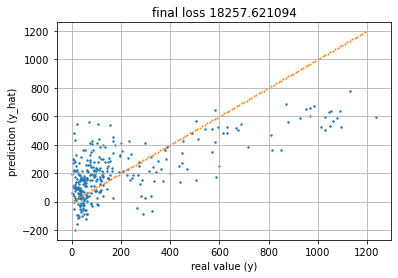

W: tensor([[  6.8810],
        [-18.1665],
        [ -0.3900],
        [ 20.4982],
        [ -7.6521],
        [ -4.9371],
        [ -5.9948],
        [ 59.9599]])
b: tensor([181.7122])


In [16]:
# 학습이 완료된 모델로부터 전체 314개 데이터에 대한 average loss를 출력하고,
# real value와 prediction을 비교합니다.
# 또한, 학습된 parameter들 w를 출력하여 각각의 feature에 대한 weight를 확인합니다.

# with torch.no_grad() - requires_grad = True 인 Tensor(weight, bias)의 연산기록 추적을 멈춤
# with로 묶은 범위 내에서 grad 사용 안함
with torch.no_grad():
    y_hat = lin_model(X, W, b)
    train_l = loss(y_hat, y)
    print(f'average loss: {float(train_l.mean()):f}')

plt.scatter(y,y_hat,2)
plt.scatter(np.arange(0,1200,10),np.arange(0,1200,10),1)
plt.grid('on')
plt.xlabel('real value (y)')

plt.ylabel('prediction (y_hat)')
plt.title(f'final loss {float(train_l.mean()):f}')
plt.show()

# 각 weight들의 값과 bias 값 출력
# .dethach()를 사용하여 기존 Tensor에서 gradient 업데이트가 일어나지 않는 텐서를 생성하여 출력
print('W:',W.detach())
print('b:',b.detach())

In [17]:
X.shape

torch.Size([314, 8])

In [18]:
y.shape

torch.Size([314])

In [19]:
y_hat.shape

torch.Size([314, 1])